# **Clinopyroxene and clinopyroxene-liquid thermo-barometers**

This script applies pre-trained models to your data set and it gives you back pressure or temperature estimates of your samples in kbar and °C, respectively.
What do you need to do?
1. You just need to replace the values of the oxides you find in the "Unknowns-template.xlsx" (in the datasets folder) with your own measurements. Do not change the name of the file or the name of the columns!
2. Select between 'cpx_only' or 'cpx_liquid' and  'Temperature' or 'Pressure' on the next cell.
3. Press the "restart the kernel and run all cells" button and to get your results! You will have an excel file in the "out-files" folder with your results.

# Settings

In [2]:
model = 'cpx_liquid' # 'cpx_only' or 'cpx_liquid'
output = 'Temperature' # 'Temperature' or 'Pressure'
p = 1000  

# Import

In [1]:
import numpy as np
import pandas as pd
import json
import onnxruntime as rt
import scipy.stats as st
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as RMSE
from ML_PT_Pyworkflow import*

import warnings
warnings.filterwarnings('ignore')

# Data Loading

In [3]:
df_init  = Dataset.Unknowns
df  = data_imputation(df_init)

Elements_Cpx = ['SiO2_Cpx', 'TiO2_Cpx', 'Al2O3_Cpx', 'FeOt_Cpx', 'MgO_Cpx', 'MnO_Cpx', 'CaO_Cpx',  'Na2O_Cpx', 'Cr2O3_Cpx']
Elements_Liq = ['SiO2_Liq', 'TiO2_Liq', 'Al2O3_Liq', 'FeOt_Liq', 'MgO_Liq', 'MnO_Liq', 'CaO_Liq',  'Na2O_Liq', 'K2O_Liq']

if model == 'cpx_only':
    for element in Elements_Cpx:
        df_m = replace_zeros(df, element)
    sample_names = df['Sample_ID'] 
    Xd = df[Elements_Cpx]
    X = np.array(Xd)
        
elif model == 'cpx_liquid':
    for element in Elements_Cpx:
        df_m = replace_zeros(df, element) 
    for element in Elements_Liq:
        df_m = replace_zeros(df, element)
    sample_names = df['Sample_ID'] 
    Xd = df[Elements_Cpx+Elements_Liq]
    X = np.array(Xd)

# Data Perturbation

In [4]:
std_dev_perc = Parameters.oxide_rel_err
K = Parameters.K_rel_err

if model == 'cpx_only':
    std_dev_perc = std_dev_perc
            
elif model == 'cpx_liquid':
    std_dev_perc_temp_1 = std_dev_perc
    std_dev_perc_temp_2 = std_dev_perc[:-1]
    std_dev_perc = np.concatenate((std_dev_perc_temp_1,std_dev_perc_temp_2,K),axis=None)

In [5]:
X_perturb, groups = input_perturbation(X,std_dev_perc ,n_perturbations=p)

# Model Prediction

In [6]:
scaler, predictor, bias_json = P_T_predictors(output, model)
X_perturb_s = scaler.transform(X_perturb)

bias_popt_left = np.array(bias_json['slope']['left'])
bias_popt_right = np.array(bias_json['slope']['right'])
ang_left = bias_json['angle']['left']
ang_right = bias_json['angle']['right']

input_name = predictor.get_inputs()[0].name  
label_name = predictor.get_outputs()[0].name 
y_pred = predictor.run([label_name],{input_name: X_perturb_s.astype(np.float32)})[0]


In [7]:
unit = 'kbar' if output == 'Pressure' else 'C'

unique_y_pred = np.apply_along_axis(np.median,1, np.split(y_pred[:,0],len(y_pred)/p))
unique_y_perc_max = np.apply_along_axis(max_perc,1, np.split(y_pred[:,0],len(y_pred)/p))
unique_y_perc_min = np.apply_along_axis(min_perc,1, np.split(y_pred[:,0],len(y_pred)/p))

bias_temp = bias_f(unique_y_pred,
                   ang_left, bias_popt_left, 
                   ang_right, bias_popt_right)

unique_y_pred = unique_y_pred - bias_temp
unique_y_perc_max = unique_y_perc_max - bias_temp
unique_y_perc_min = unique_y_perc_min - bias_temp

error = (unique_y_perc_max - unique_y_perc_min)/2
predictions = pd.DataFrame(data=np.transpose(np.array([unique_y_pred,unique_y_perc_max,unique_y_perc_min])),    
             columns=[output+'_'+unit, 'Percentile_84', 'Percentile_16'])  

print('Predictions:')
print(predictions)

df_orig = df_init
df_orig['Sample_ID'] = df_orig['Sample_ID'].astype(str)

if model == 'cpx_only':
    df_orig = pd.concat([df_orig['Sample_ID'], df_orig[Elements_Cpx]], axis=1)
    output_file_name = 'out-files/Results_cpx_only_' + output + '.xlsx'
    
elif model == 'cpx_liquid':
    df_orig = pd.concat([df_orig['Sample_ID'], df_orig[Elements_Cpx + Elements_Liq]], axis=1)
    output_file_name = 'out-files/Results_cpx_liquid_' + output + '.xlsx'
    
finaldf = pd.concat([df_orig, predictions], axis=1)    
print(finaldf.head())


print(finaldf.head())
finaldf.to_excel(output_file_name, sheet_name=output, index=False)


Predictions:
     Temperature_C  Percentile_84  Percentile_16
0      1139.245605    1139.414795    1138.755840
1      1296.646240    1314.672910    1276.815474
2      1015.845764    1017.381978    1014.765881
3      1337.841064    1345.050371    1330.415322
4      1267.686890    1269.444292    1264.922632
..             ...            ...            ...
352    1299.786499    1300.884478    1298.803706
353    1181.021240    1189.718467    1176.125659
354     969.513367     971.243132     968.075525
355    1200.239502    1206.009165    1195.778647
356    1032.720459    1038.613369    1027.745713

[357 rows x 3 columns]
  Sample_ID  SiO2_Cpx  TiO2_Cpx  Al2O3_Cpx  FeOt_Cpx  MgO_Cpx  MnO_Cpx  \
0      1542     51.98      0.26       1.54  12.82994    15.66     0.57   
1      1113     50.30      1.01       8.76   7.50000    13.90     0.16   
2      2020     50.10      0.57       4.17   6.63000    14.50     0.21   
3       173     49.10      0.45      12.30   7.12000    15.80     0.16   
4    

# Data Visualization

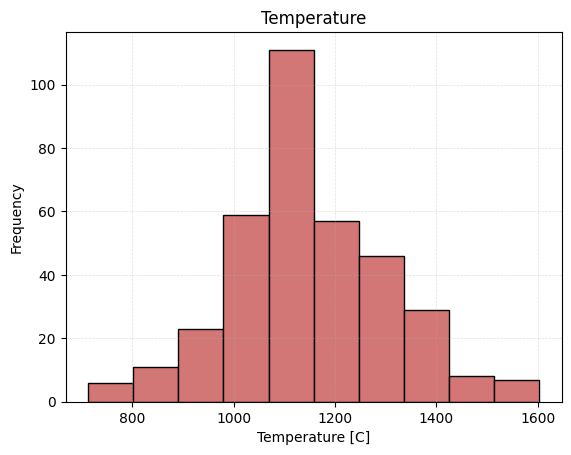

In [10]:
# Plot histogram
My_color = '#9BB0C1' if output == 'Pressure' else '#D37676'
plt.hist(finaldf[output+'_'+unit], color=My_color, edgecolor='black')
plt.xlabel(output+' ['+unit+']')
plt.ylabel('Frequency')
plt.title(output)
plt.grid(color='#B2B2B2', linestyle='--', linewidth=0.5, alpha=0.4)
plt.savefig('Figures/'+'Results_'+output+ ('_cpx' if model== 'cpx_only' else '_cpx_liq') +'.pdf', format='pdf')
